In [ ]:
from google.colab import files
uploaded = files.upload()  # Click "Choose Files" and select your products.csv

Saving MSFT_stock_features.csv to MSFT_stock_features.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
def load_data(ticker="MSFT"):
    df = pd.read_csv(f"{ticker}_stock_features.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

ticker = "MSFT"
data = load_data(ticker)
print(data.head())  # Verify all features are loaded

                 Close        High         Low        Open      Volume  \
Date                                                                     
2020-10-15  211.349091  212.022603  207.837181  208.885951  22733100.0   
2020-10-16  211.349091  213.879574  211.021958  211.820542  26057900.0   
2020-10-19  206.114944  213.889238  205.633862  212.080363  27625800.0   
2020-10-20  206.528641  209.145730  205.027666  207.635139  22753500.0   
2020-10-21  206.672989  208.712773  205.056544  205.056544  22724900.0   

                  MA10        MA50       MA100       MA200        RSI  \
Date                                                                    
2020-10-15  206.238097  203.882423  197.775834  179.449973  63.430009   
2020-10-16  207.534132  203.956157  198.144232  179.740102  62.034776   
2020-10-19  207.903603  203.999500  198.464223  180.013607  57.611503   
2020-10-20  208.744536  204.132321  198.770594  180.287222  55.013913   
2020-10-21  209.222731  204.361516  199.082

In [26]:
# Select features and target
features = ['Close', 'MA100', 'RSI', 'Norm_Volume', 'Bollinger_Upper', 'Bollinger_Lower']
data = data[features]  # Keep only selected features

In [27]:
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    if max_val == min_val:
        return np.zeros_like(data), min_val, max_val
    return (data - min_val) / (max_val - min_val), min_val, max_val

In [28]:
def scale_features(df):
    scaled_data = {}
    scalers = {}
    for col in df.columns:
        scaled_values, min_val, max_val = min_max_scaling(df[col].values)
        if col == 'Close':
            scalers['target'] = (min_val, max_val)
        else:
            scalers[col] = (min_val, max_val)
        scaled_data[col] = scaled_values
    return pd.DataFrame(scaled_data), scalers

# Scale all features
scaled_data, scalers = scale_features(data)


In [44]:
# Create sequences (for LSTM-style or sliding window)
def create_sequences(df, seq_length):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df.iloc[i:i + seq_length].values)
        y.append(df.iloc[i + seq_length]['Close'])  # Predict next 'Close'
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_data, seq_length)

# Split into train/test
split_ratio = 0.7
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Flatten for decision trees
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))


In [45]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=5, min_samples_split=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)

    def best_split(self, X, y):
        best_feature, best_threshold, best_mse = None, None, float('inf')
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left = y[X[:, feature] <= t]
                right = y[X[:, feature] > t]
                if len(left) < self.min_samples_split or len(right) < self.min_samples_split:
                    continue
                mse_split = (len(left) * self.mse(left) + len(right) * self.mse(right)) / len(y)
                if mse_split < best_mse:
                    best_mse = mse_split
                    best_feature = feature
                    best_threshold = t
        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(y) < self.min_samples_split:
            return np.mean(y)
        feature, threshold = self.best_split(X, y)
        if feature is None:
            return np.mean(y)
        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold
        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)
        return (feature, threshold, left_subtree, right_subtree)

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict_one(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, threshold, left, right = node
        if x[feature] <= threshold:
            return self.predict_one(x, left)
        else:
            return self.predict_one(x, right)

    def predict(self, X):
        return np.array([self.predict_one(x, self.tree) for x in X])


In [46]:
class RandomForestRegressor:
    def __init__(self, n_trees=10, max_depth=5, min_samples_split=10, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        self.max_features = max_features

    def bootstrap(self, X, y):
        idxs = np.random.randint(0, len(X), len(X))
        return X[idxs], y[idxs]

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTreeRegressor(self.max_depth, self.min_samples_split)
            X_sample, y_sample = self.bootstrap(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)


In [47]:
# Train model
rf_model = RandomForestRegressor(n_trees=20, max_depth=6, min_samples_split=5)
rf_model.fit(X_train, y_train)

In [48]:
# Predict and inverse scale
def get_inverse_scaled_predictions(pred_scaled):
    min_target, max_target = scalers['target']
    return np.array(pred_scaled) * (max_target - min_target) + min_target

y_test_actual = get_inverse_scaled_predictions(y_test)
predictions = get_inverse_scaled_predictions(rf_model.predict(X_test))

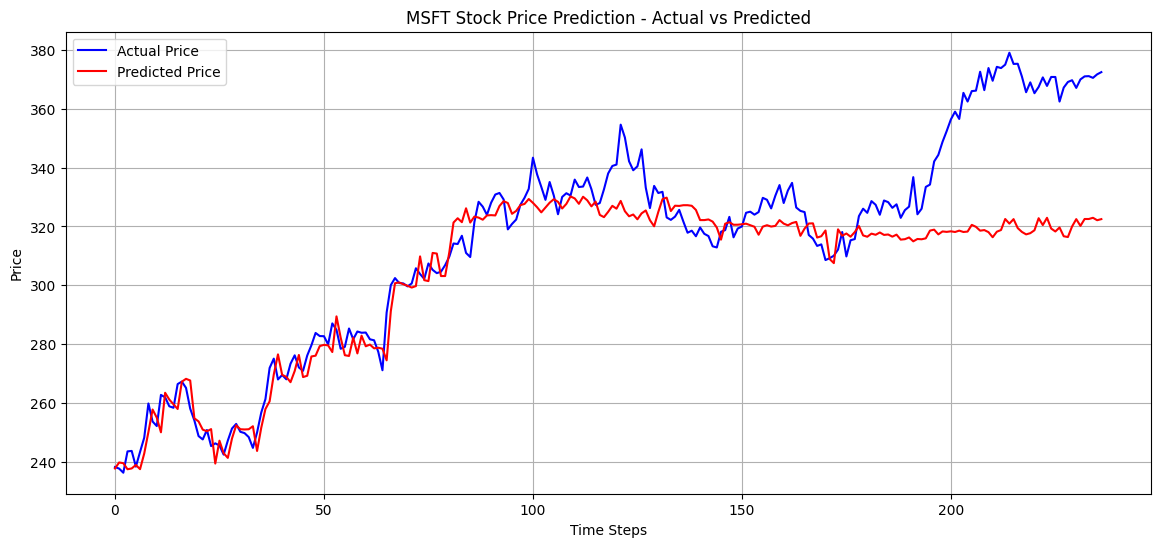

In [49]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='red')
plt.title(f"{ticker} Stock Price Prediction - Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Align test dates
test_dates = data.index[seq_length + split_index:]

results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': y_test_actual,
    'Predicted Price': predictions
})
results_df['Actual Price'] = results_df['Actual Price'].round(2)
results_df['Predicted Price'] = results_df['Predicted Price'].round(2)
print(results_df.head(10))

        Date  Actual Price  Predicted Price
0 2023-01-23        238.19           237.70
1 2023-01-24        237.66           239.73
2 2023-01-25        236.25           239.49
3 2023-01-26        243.51           237.43
4 2023-01-27        243.66           237.70
5 2023-01-30        238.31           238.89
6 2023-01-31        243.32           237.46
7 2023-02-01        248.17           242.78
8 2023-02-02        259.81           250.08
9 2023-02-03        253.67           257.74


In [51]:
# Compute Returns
actual_returns = np.diff(y_test_actual) / y_test_actual[:-1]
predicted_returns = np.diff(predictions) / predictions[:-1]

In [52]:
# Compute Volatility
window = 10
actual_volatility = pd.Series(actual_returns).rolling(window).std().fillna(0)
predicted_volatility = pd.Series(predicted_returns).rolling(window).std().fillna(0)

In [56]:
final_df = pd.DataFrame({
    'Date': test_dates[1:],  # np.diff removes one row
    'Actual Return': actual_returns,
    'Predicted Return': predicted_returns,
    'Actual Volatility': actual_volatility,
    'Predicted Volatility': predicted_volatility
})
print(final_df.tail(10))

          Date  Actual Return  Predicted Return  Actual Volatility  \
226 2023-12-15       0.013117         -0.009321           0.012031   
227 2023-12-18       0.005179         -0.000845           0.011170   
228 2023-12-19       0.001637          0.011371           0.010807   
229 2023-12-20      -0.007073          0.007796           0.010537   
230 2023-12-21       0.007879         -0.007143           0.010670   
231 2023-12-22       0.002784          0.007327           0.010326   
232 2023-12-26       0.000214          0.000000           0.009942   
233 2023-12-27      -0.001575          0.001269           0.009616   
234 2023-12-28       0.003235         -0.002560           0.009672   
235 2023-12-29       0.002025          0.001164           0.005409   

     Predicted Volatility  
226              0.007719  
227              0.007683  
228              0.008525  
229              0.008793  
230              0.008098  
231              0.008121  
232              0.007735  
233  

In [57]:
final_df['Return Error'] = final_df['Actual Return'] - final_df['Predicted Return']
final_df['Volatility Error'] = final_df['Actual Volatility'] - final_df['Predicted Volatility']
final_df['Abs Return Error'] = final_df['Return Error'].abs()
final_df['Abs Volatility Error'] = final_df['Volatility Error'].abs()

In [58]:
# Metrics
mae_return = final_df['Abs Return Error'].mean()
mae_volatility = final_df['Abs Volatility Error'].mean()
mse_return = (final_df['Return Error'] ** 2).mean()
mse_volatility = (final_df['Volatility Error'] ** 2).mean()

In [59]:
# Print results
print(f"MAE (Return): {mae_return:.6f}")
print(f"MAE (Volatility): {mae_volatility:.6f}")
print(f"MSE (Return): {mse_return:.6f}")
print(f"MSE (Volatility): {mse_volatility:.6f}")

MAE (Return): 0.015450
MAE (Volatility): 0.006436
MSE (Return): 0.000408
MSE (Volatility): 0.000059


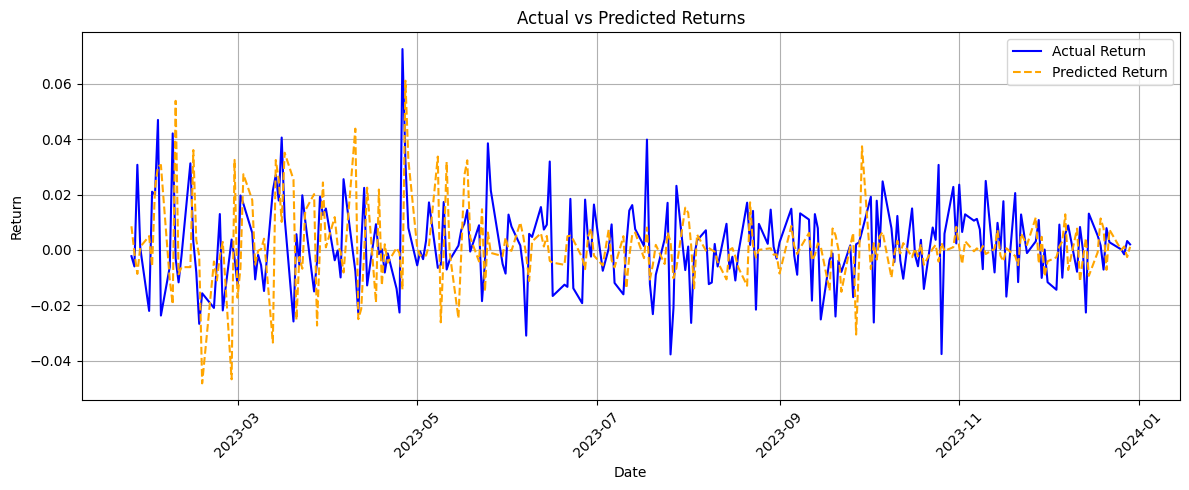

In [60]:
# Plot 1: Return
plt.figure(figsize=(12, 5))
plt.plot(final_df['Date'], final_df['Actual Return'], label='Actual Return', color='blue')
plt.plot(final_df['Date'], final_df['Predicted Return'], label='Predicted Return', color='orange', linestyle='--')
plt.title("Actual vs Predicted Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

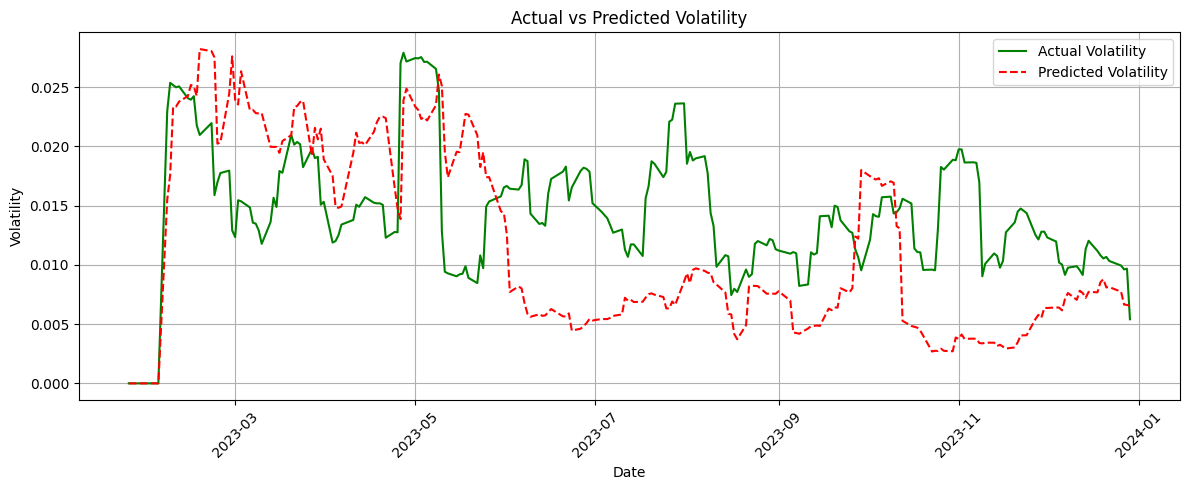

In [61]:
# Plot 2: Volatility
plt.figure(figsize=(12, 5))
plt.plot(final_df['Date'], final_df['Actual Volatility'], label='Actual Volatility', color='green')
plt.plot(final_df['Date'], final_df['Predicted Volatility'], label='Predicted Volatility', color='red', linestyle='--')
plt.title("Actual vs Predicted Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()